In [11]:
import numba
import numpy as np
import random as rd 
import matplotlib.pyplot as plt
import time
from numba import jit, config, threading_layer, set_num_threads
from numpy.random import random as npr
from numpy.random import default_rng
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()


# seeds
rd.seed(42)
np.random.seed(42)
rng = default_rng(seed=42)


# Teq = tempo de equilibrio
Teq = 10**4
# T = tempo de simulação
T = 10**6 - Teq

pm = 50 # tempo entre medidas




      


In [12]:
def init_viz(L2):
    viz = np.zeros((L2,4),dtype=np.int64)
    L = L2**(1/2)
    for sitio in range(L2):
        n1 = ((sitio//L -1 +L2)%L)*L + sitio%L
        n2 = ((sitio//L)%L)*L+(sitio+1+L)%L
        n3 = ((sitio//L +1 +L2)%L)*L +sitio%L
        n4 = ((sitio//L)%L)*L+(sitio-1+L)%L
    
        viz[sitio][0] = n1
        viz[sitio][1] = n2
        viz[sitio][2] = n3
        viz[sitio][3] = n4
    return viz

def init_medidas(L2,s, viz):
    E = 0 
    mag = np.sum(s)                         
    viz = init_viz(L2)                      
    for i in range(L2):
      for j in range(4):
        E = E + s[i]*(s[viz[i][j]])
    E = E*(-1/2)
    
    return E, mag
    
    

# funcao responsavel pelos MCS
@jit(nopython=True)
def passo(L2,s, mag, E, viz, TEMP):
    for i in range(L2):
             sitio = np.random.randint(L2) # vou escolher um sitio aleatorio
             deltae = 2*s[sitio]*(s[viz[sitio,0]] + s[viz[sitio,1]] +s[viz[sitio,2]]+s[viz[sitio,3]])
             prob = np.exp(-deltae/TEMP)
             rfloat1 = npr(1)[0]  # num aleatorio [0,1) | npr() = numpy.random.random()
             if rfloat1 < prob: # if para flipar o sitio
                 s[sitio] = s[sitio]*(-1)
                 mag = mag + 2*s[sitio] # ajustamos a mag
                 E = E + deltae
             
    return mag, E
            
    
def dinamica(L2, s, TEMP):
  viz = init_viz(L2)            # iniciando vizinhos
  E, mag = init_medidas(L2,s, viz) # iniciando energia e mag

  Elist = []
  maglist =[]
  for t in range(Teq):              # loop para equilibrar
      mag, E = passo(L2,s, mag, E, viz, TEMP)

  for t in range(T):                # loop com medidas
      mag, E = passo(L2,s, mag, E, viz, TEMP)

      Elist.append(E)
      maglist.append(mag)


  return  np.array(maglist), np.array(Elist)
    





  

In [29]:
def biden(L,temps=np.linspace(2, 3 , 30), RunTime=10**5, historias= 1):
  L2 = L*L
  # Teq = tempo de equilibrio
  Teq = 10**4
  # T = tempo de simulação
  T = RunTime - Teq


  Tb = []
  for temp in temps:
    blist = []

    for h in range(historias):
      Sr = np.array(rd.choices([-1,1], k=L2), dtype=np.float32)

      mag, E = dinamica(L2,Sr, temp)



      mageq2 = np.mean(((mag/L2)**2))
      mageq4 = np.mean(((mag/L2)**4))

      blist.append(1-1/3*(mageq4/(mageq2**2)))



    Tb.append(np.mean(blist))





  return np.array(Tb)

In [35]:
temps=np.linspace(2, 3 , 50)
T = 10**6
b4 = biden(4, temps=temps,RunTime=T )
b8 = biden(8, temps=temps,RunTime=T)
b16 = biden(16, temps=temps,RunTime=T)

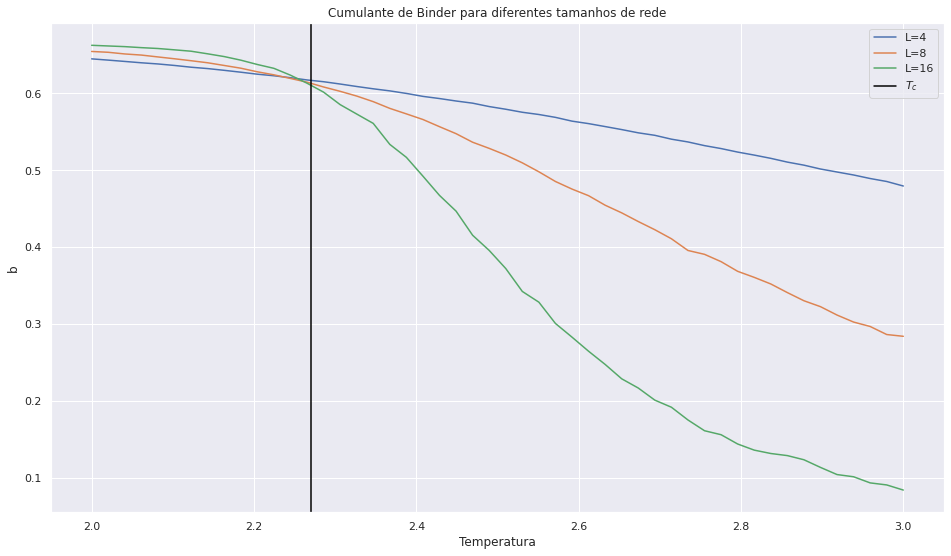

In [37]:
plt.rcParams["figure.figsize"] = (16,9)
plt.plot(temps, b4, label ='L=4')
plt.plot(temps, b8, label ='L=8')
plt.plot(temps, b16, label ='L=16')
plt.axvline(2.27, label='$T_c$',color='black')
plt.xlabel('Temperatura')
plt.ylabel('b')
plt.legend()
plt.title('Cumulante de Binder para diferentes tamanhos de rede')
plt.savefig('Tarefa9.pdf')